# Set-up

In [156]:
import os
import sys
import numpy as np
import pandas as pd

import pyranges as pr
import pybedtools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os as _os
import sys as _sys
try:
    _bin_dir = _os.path.dirname(_sys.executable)
    _os.environ["PATH"] += _os.pathsep + _bin_dir
    from pybedtools import paths as _paths
    _paths._set_bedtools_path(_bin_dir)
except ImportError:
    raise ImportError(
        "Please install pybedtools (pip install pybedtools"
    )

In [223]:
def venn_mpl(a, b, c, colors=None, outfn="out.png", labels=None, by_length=False, dpi=300):
    """
    *a*, *b*, and *c* are filenames to BED-like files.

    *colors* is a list of matplotlib colors for the Venn diagram circles.

    *outfn* is the resulting output file.  This is passed directly to
    fig.savefig(), so you can supply extensions of .png, .pdf, or whatever your
    matplotlib installation supports.

    *labels* is a list of labels to use for each of the files; by default the
    labels are ['a','b','c']

    *by_length* if True, then instead of plotting number of intervals, plot combined
    lengths of intervals

    *dpi* is the dpi setting passed to matplotlib savefig
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.patches import Circle
    except ImportError:
        sys.stderr.write(
            "matplotlib is required to make a Venn diagram with %s\n"
            % os.path.basename(sys.argv[0])
        )
        sys.exit(1)

    a = pybedtools.BedTool(a)
    b = pybedtools.BedTool(b)
    c = pybedtools.BedTool(c)
    count_features = lambda x:x.count()
    if by_length:
        count_features = lambda x:x.total_coverage()

    if colors is None:
        colors = ["r", "b", "g"]

    radius = 6.0
    center = 0.0
    offset = radius / 2

    if labels is None:
        labels = ["a", "b", "c"]

    circle_a = Circle(
        xy=(center - offset, center + offset),
        radius=radius,
        edgecolor=colors[0],
        label=labels[0],
    )
    circle_b = Circle(
        xy=(center + offset, center + offset),
        radius=radius,
        edgecolor=colors[1],
        label=labels[1],
    )
    circle_c = Circle(
        xy=(center, center - offset),
        radius=radius,
        edgecolor=colors[2],
        label=labels[2],
    )

    fig = plt.figure(facecolor="w")
    ax = fig.add_subplot(111)

    for circle in (circle_a, circle_b, circle_c):
        circle.set_facecolor("none")
        circle.set_linewidth(3)
        ax.add_patch(circle)

    ax.axis("tight")
    ax.axis("equal")
    ax.set_axis_off()

    kwargs = dict(horizontalalignment="center")

    # Unique to A
    ax.text(center - 2 * offset, center + offset, str(count_features(a - b - c)), **kwargs)

    # Unique to B
    ax.text(center + 2 * offset, center + offset, str(count_features(b - a - c)), **kwargs)

    # Unique to C
    ax.text(center, center - 2 * offset, str(count_features(c - a - b)), **kwargs)

    # A and B not C
    ax.text(
        center, center + 2 * offset - 0.5 * offset, str(count_features(a + b - c)), **kwargs
    )

    # A and C not B
    ax.text(
        center - 1.2 * offset, center - 0.5 * offset, str(count_features(a + c - b)), **kwargs
    )

    # B and C not A
    ax.text(
        center + 1.2 * offset, center - 0.5 * offset, str(count_features(b + c - a)), **kwargs
    )

    # all
    ax.text(center, center, str(count_features(a + b + c)), **kwargs)

    ax.legend(loc="best")

    fig.savefig(outfn, dpi=dpi)

    plt.close(fig)


# Same thing but just a simple 2-way venn
def venn2_mpl(a, b, colors=None, outfn="out.png", labels=None, by_length=False, dpi=300):
    """
    *a* and *b* are filenames to BED-like files.

    *colors* is a list of matplotlib colors for the Venn diagram circles.

    *outfn* is the resulting output file.  This is passed directly to
    fig.savefig(), so you can supply extensions of .png, .pdf, or whatever your
    matplotlib installation supports.

    *labels* is a list of labels to use for each of the files; by default the
    labels are ['a','b']

    *by_length* if True, then instead of plotting number of intervals, plot combined
    lengths of intervals

    *dpi* is the dpi setting passed to matplotlib savefig
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.patches import Circle
    except ImportError:
        sys.stderr.write(
            "matplotlib is required to make a Venn diagram with %s\n"
            % os.path.basename(sys.argv[0])
        )
        sys.exit(1)

    a = pybedtools.BedTool(a)
    b = pybedtools.BedTool(b)
    count_features = lambda x:x.count()
    if by_length:
        count_features = lambda x:x.total_coverage()

    if colors is None:
        colors = ["r", "b"]

    radius = 6.0
    center = 0.0
    offset = radius / 2

    if labels is None:
        labels = ["a", "b"]

    circle_a = Circle(
        xy=(center - offset, center),
        radius=radius,
        edgecolor=colors[0],
        label=labels[0],
    )
    circle_b = Circle(
        xy=(center + offset, center),
        radius=radius,
        edgecolor=colors[1],
        label=labels[1],
    )

    fig = plt.figure(facecolor="w")
    ax = fig.add_subplot(111)

    for circle in (circle_a, circle_b):
        circle.set_facecolor("none")
        circle.set_linewidth(3)
        ax.add_patch(circle)

    ax.axis("tight")
    ax.axis("equal")
    ax.set_axis_off()

    kwargs = dict(horizontalalignment="center")

    # Unique to A
    ax.text(center - 2 * offset, center, str(count_features(a - b)), **kwargs)

    # Unique to B
    ax.text(center + 2 * offset, center, str(count_features(b - a)), **kwargs)

    # all
    ax.text(center, center, str(count_features(a + b)), **kwargs)

    ax.legend(loc="best")

    fig.savefig(outfn, dpi=dpi)

    plt.close(fig)

In [158]:
# Function to create fixed-width peaks centered on the summit
def to_fixed_width_from_summit(feature, width, feature_index=9):
    if feature_index is None:
        summit_position = (feature.start + feature.end) // 2
    else:
        summit_position = feature.start + int(feature[feature_index])  # Summit position in the chromosome
        if summit_position > 1e10:
            print(f"Summit position is {summit_position}, setting summit to middle of the peak.")
            summit_position = (feature.start + feature.end) // 2
    
    start = max(0, summit_position - width // 2)
    end = start + width
    feature.start = start
    feature.end = end
    return feature

def create_fixed_width_peaks(narrow_peak_file, fixed_width, feature_index=9):
    peaks = pybedtools.BedTool(narrow_peak_file)
    fixed_width_peaks = peaks.each(to_fixed_width_from_summit, fixed_width, feature_index=feature_index)
    return fixed_width_peaks

In [159]:
outdir = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/fixed_width_peaks"
os.makedirs(outdir, exist_ok=True)
os.chdir(outdir)

In [160]:
# Path to blacklist
blacklist_path = "/cellar/users/aklie/data/ref/genomes/hg38/blacklist/blacklist.bed.gz"
blacklist = pr.read_bed(blacklist_path)
blacklist

,Chromosome,Start,End
0,chr1,628903,635104
1,chr1,5850087,5850571
2,chr1,8909610,8910014
3,chr1,9574580,9574997
4,chr1,32043823,32044203
...,...,...,...
905,chrY,11290797,11334278
906,chrY,11493053,11592850
907,chrY,11671014,11671046
908,chrY,11721528,11749472


# 1kb fixed width consensus peaks

In [242]:
# Peaks sets to compare
peakset1 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/snapatac2/filtered_no_replicate/peak_calls/consensus_peaks.bed"
peakset2 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/snapatac2/filtered/peak_calls/consensus_peaks.bed"
peakset3 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/filtered_archr/PeakCalls/SplitPeaks/consensus_peaks.bed"
peakset4 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/filtered_signac/peaks/consensus_peaks.bed"

In [243]:
# Load bedtool objects
peaks1_tool = pybedtools.BedTool(peakset1)
peaks2_tool = pybedtools.BedTool(peakset2)
peaks3_tool = pybedtools.BedTool(peakset3)
peaks4_tool = pybedtools.BedTool(peakset4)
len(peaks1_tool), len(peaks2_tool), len(peaks3_tool), len(peaks4_tool)

(327816, 99020, 188090, 98010)

In [244]:
fixed_width_peaks1_tool = peaks1_tool.slop(b=250, genome="hg38").saveas('snapatac2.filtered_no_replicate.consensus.fixed_width_peaks.bed')
fixed_width_peaks2_tool = peaks2_tool.slop(b=250, genome="hg38").saveas('snapatac2.filtered.consensus.fixed_width_peaks.bed')
fixed_width_peaks3_tool = peaks3_tool.slop(b=250, genome="hg38").saveas('archr.filtered.consensus.fixed_width_peaks.bed')
fixed_width_peaks4_tool = create_fixed_width_peaks(peakset4, 1000, None)
fixed_width_peaks4_tool.saveas('signac.filtered.consensus.fixed_width_peaks.bed')

<BedTool(signac.filtered.consensus.fixed_width_peaks.bed)>

In [245]:
# update file paths
fixed_width_peaks1 = "snapatac2.filtered_no_replicate.consensus.fixed_width_peaks.bed"
fixed_width_peaks2 = "snapatac2.filtered.consensus.fixed_width_peaks.bed"
fixed_width_peaks3 = "archr.filtered.consensus.fixed_width_peaks.bed"
fixed_width_peaks4 = "signac.filtered.consensus.fixed_width_peaks.bed"

In [246]:
venn_mpl(fixed_width_peaks1, fixed_width_peaks3, fixed_width_peaks4, outfn="fixed_width_consensus-filt.png", labels=["SnapATAC2 (non-reproducible)", "ArchR (filtered)", "Signac (filtered)"])

In [247]:
venn_mpl(fixed_width_peaks2, fixed_width_peaks3, fixed_width_peaks4, outfn="fixed_width_consensus-filt_reprodocuble.png", labels=["SnapATAC2 (reproducible)", "ArchR (filtered)", "Signac (filtered)"])

In [248]:
venn_mpl(fixed_width_peaks1, fixed_width_peaks2, fixed_width_peaks3, outfn="fixed_width_consensus_archr-filt.png", labels=["SnapATAC2", "SnapATAC2 (reproducible)", "ArchR (filtered)"])

In [249]:
fixed_width_peaks1_tool = pybedtools.BedTool(fixed_width_peaks1)
fixed_width_peaks2_tool = pybedtools.BedTool(fixed_width_peaks2)
fixed_width_peaks3_tool = pybedtools.BedTool(fixed_width_peaks3)
fixed_width_peaks4_tool = pybedtools.BedTool(fixed_width_peaks4)
len(fixed_width_peaks1_tool), len(fixed_width_peaks2_tool), len(fixed_width_peaks3_tool), len(fixed_width_peaks4_tool)

(327816, 99020, 188090, 98010)

In [250]:
(fixed_width_peaks1_tool + fixed_width_peaks2_tool).count(), (fixed_width_peaks2_tool + fixed_width_peaks1_tool).count()

(118365, 99020)

In [251]:
fixed_width_peaks1_tool.intersect(fixed_width_peaks2_tool, u=True).count(), fixed_width_peaks1_tool.intersect(fixed_width_peaks2_tool, u=False).count()

(118365, 157869)

In [252]:
fixed_width_peaks2_tool.intersect(fixed_width_peaks1_tool, u=True).count(), fixed_width_peaks2_tool.intersect(fixed_width_peaks1_tool, u=False).count()

(99020, 157869)

In [253]:
(fixed_width_peaks1_tool + fixed_width_peaks3_tool).count(), (fixed_width_peaks3_tool + fixed_width_peaks1_tool).count()

(150805, 159618)

In [254]:
fixed_width_peaks1_tool.intersect(fixed_width_peaks3_tool, u=True).count(), fixed_width_peaks1_tool.intersect(fixed_width_peaks3_tool, u=False).count()

(150805, 236718)

In [255]:
fixed_width_peaks3_tool.intersect(fixed_width_peaks1_tool, u=True).count(), fixed_width_peaks3_tool.intersect(fixed_width_peaks1_tool, u=False).count()

(159618, 236718)

In [256]:
(fixed_width_peaks1_tool + fixed_width_peaks4_tool).count(), (fixed_width_peaks4_tool + fixed_width_peaks1_tool).count()

(137046, 97951)

In [257]:
fixed_width_peaks1_tool.intersect(fixed_width_peaks4_tool, u=True).count(), fixed_width_peaks1_tool.intersect(fixed_width_peaks4_tool, u=False).count()

(137046, 144300)

In [258]:
fixed_width_peaks4_tool.intersect(fixed_width_peaks1_tool, u=True).count(), fixed_width_peaks4_tool.intersect(fixed_width_peaks1_tool, u=False).count()

(97951, 144300)

In [259]:
(fixed_width_peaks1_tool + fixed_width_peaks3_tool + fixed_width_peaks4_tool).count()

116835

In [260]:
(fixed_width_peaks1_tool + fixed_width_peaks4_tool + fixed_width_peaks3_tool).count()

116835

In [261]:
(fixed_width_peaks4_tool + fixed_width_peaks3_tool + fixed_width_peaks1_tool).count()

82195

In [262]:
(fixed_width_peaks4_tool + fixed_width_peaks1_tool + fixed_width_peaks3_tool).count()

82195

In [263]:
(fixed_width_peaks3_tool + fixed_width_peaks4_tool + fixed_width_peaks1_tool).count()

119096

In [264]:
(fixed_width_peaks3_tool + fixed_width_peaks1_tool + fixed_width_peaks4_tool).count()

119096

In [265]:
venn2_mpl(fixed_width_peaks2, fixed_width_peaks3, outfn="fixed_width_consensus_snapatac2repro_archr.png", labels=["SnapATAC2 (reproducible)", "ArchR"], colors=["#1f77b4", "#2ca02c"])
venn2_mpl(fixed_width_peaks3, fixed_width_peaks2, outfn="fixed_width_consensus_archr_snapatac2repro.png", labels=["ArchR", "SnapATAC2 (reproducible)"], colors=["#2ca02c", "#1f77b4"])
venn2_mpl(fixed_width_peaks2, fixed_width_peaks4, outfn="fixed_width_consensus_snapatac2repro_signac.png", labels=["SnapATAC2 (reproducible)", "Signac"], colors=["#1f77b4", "#d62728"])
venn2_mpl(fixed_width_peaks4, fixed_width_peaks2, outfn="fixed_width_consensus_signac_snapatac2repro.png", labels=["Signac", "SnapATAC2 (reproducible)"], colors=["#d62728", "#1f77b4"])
venn2_mpl(fixed_width_peaks3, fixed_width_peaks4, outfn="fixed_width_consensus_archr_signac.png", labels=["ArchR", "Signac"], colors=["#2ca02c", "#d62728"])
venn2_mpl(fixed_width_peaks4, fixed_width_peaks3, outfn="fixed_width_consensus_signac_archr.png", labels=["Signac", "ArchR"], colors=["#d62728", "#2ca02c"])

In [228]:
venn2_mpl(fixed_width_peaks1, fixed_width_peaks2, outfn="fixed_width_consensus_snapatac2non_snapatac2_repro.png", labels=["SnapATAC2 (non-reproducible)", "SnapATAC2 (reproducible)"], colors=["#1f77b4", "#ff7f0e"])
venn2_mpl(fixed_width_peaks2, fixed_width_peaks1, outfn="fixed_width_consensus_snapatac2repro_snapatac2non.png", labels=["SnapATAC2 (reproducible)", "SnapATAC2 (non-reproducible)"], colors=["#ff7f0e", "#1f77b4"])
venn2_mpl(fixed_width_peaks1, fixed_width_peaks3, outfn="fixed_width_consensus_snapatac2non_archr.png", labels=["SnapATAC2 (non-reproducible)", "ArchR"], colors=["#1f77b4", "#2ca02c"])
venn2_mpl(fixed_width_peaks3, fixed_width_peaks1, outfn="fixed_width_consensus_archr_snapatac2non.png", labels=["ArchR", "SnapATAC2 (non-reproducible)"], colors=["#2ca02c", "#1f77b4"])
venn2_mpl(fixed_width_peaks1, fixed_width_peaks4, outfn="fixed_width_consensus_snapatac2non_signac.png", labels=["SnapATAC2 (non-reproducible)", "Signac"], colors=["#1f77b4", "#d62728"])
venn2_mpl(fixed_width_peaks4, fixed_width_peaks1, outfn="fixed_width_consensus_signac_snapatac2non.png", labels=["Signac", "SnapATAC2 (non-reproducible)"], colors=["#d62728", "#1f77b4"])
venn2_mpl(fixed_width_peaks3, fixed_width_peaks4, outfn="fixed_width_consensus_archr_signac.png", labels=["ArchR", "Signac"], colors=["#2ca02c", "#d62728"])
venn2_mpl(fixed_width_peaks4, fixed_width_peaks3, outfn="fixed_width_consensus_signac_archr.png", labels=["Signac", "ArchR"], colors=["#d62728", "#2ca02c"])

In [167]:
archr = (fixed_width_peaks3_tool - fixed_width_peaks2_tool - fixed_width_peaks4_tool)
archr_snapatac2 = (fixed_width_peaks3_tool + fixed_width_peaks2_tool - fixed_width_peaks4_tool)
archr_signac = (fixed_width_peaks3_tool + fixed_width_peaks4_tool - fixed_width_peaks2_tool )
common = (fixed_width_peaks3_tool + fixed_width_peaks2_tool + fixed_width_peaks4_tool)
len(archr), len(archr_snapatac2), len(archr_signac), len(common)

(58512, 10082, 11639, 107857)

In [129]:
# Only have peak scores from ArchR for consensus, would need to rerun and extract
archr_df = archr.to_dataframe()
archr_df["method"] = "archr"
archr_snapatac2_df = archr_snapatac2.to_dataframe()
archr_snapatac2_df["method"] = "archr_snapatac2"
archr_signac_df = archr_signac.to_dataframe()
archr_signac_df["method"] = "archr_signac"
common_df = common.to_dataframe()
common_df["method"] = "common"
merged = pd.concat([archr_df, archr_snapatac2_df, archr_signac_df, common_df])
merged["method"].value_counts()

common             107857
archr               58512
archr_signac        11639
archr_snapatac2     10082
Name: method, dtype: int64

Text(0.5, 1.0, 'Consensus peaks (SnapATAC2 non-reproducible)')

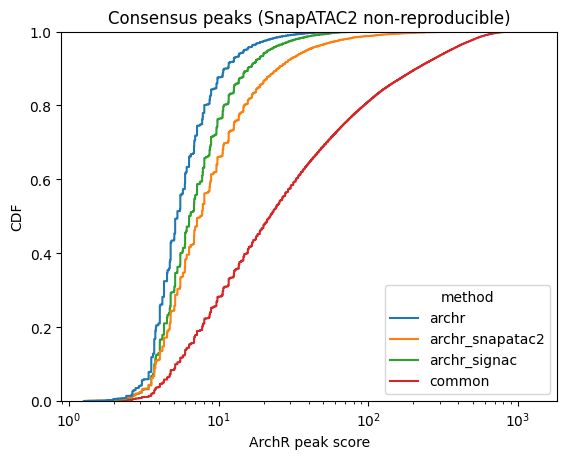

In [130]:
fig, ax = plt.subplots()
sns.ecdfplot(data=merged, x="score", hue="method", log_scale=True, ax=ax, hue_order=["archr", "archr_snapatac2", "archr_signac", "common"])
ax.set_xlabel("ArchR peak score")
ax.set_ylabel("CDF")
#legend_labels = ["ArchR unique peaks", "SnapATAC2 and ArchR union peaks"]
#ax.legend(legend_labels)
ax.set_title("Consensus peaks (SnapATAC2 non-reproducible)")

# 1kb fixed width SC.beta peaks (replicate first for SnapATAC2)

In [234]:
# Peaks sets to compare
peakset1 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/snapatac2/filtered/filtered_peaks/SC.beta.filt.narrowPeak"
peakset2 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/filtered_archr/PeakCalls/SplitPeaks/SC.beta.bed"
peakset3 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/filtered_signac/peaks/SC.beta_peaks.narrowPeak"

In [235]:
# Load bedtool objects
peaks1_tool = pybedtools.BedTool(peakset1)
peaks2_tool = pybedtools.BedTool(peakset2)
peaks3_tool = pybedtools.BedTool(peakset3)
len(peaks1_tool), len(peaks2_tool), len(peaks3_tool)

(70249, 125307, 81321)

In [236]:
fixed_width_peaks1_tool = create_fixed_width_peaks(peakset1, 1000, 12)
fixed_width_peaks1_tool.saveas('snapatac2.filtered.SC.beta.fixed_width_peaks.bed')

fixed_width_peaks2_tool = peaks2_tool.slop(b=250, genome="hg38")
fixed_width_peaks2_tool.saveas('archr.filtered.SC.beta.fixed_width_peaks.bed')

fixed_width_peaks3_tool = create_fixed_width_peaks(peakset3, 1000, 9)
fixed_width_peaks3_tool.saveas('signac.filtered.SC.beta.fixed_width_peaks.bed')

<BedTool(signac.filtered.SC.beta.fixed_width_peaks.bed)>

In [237]:
fixed_width_peaks1 = "snapatac2.filtered.SC.beta.fixed_width_peaks.bed"
fixed_width_peaks2 = "archr.filtered.SC.beta.fixed_width_peaks.bed"
fixed_width_peaks3 = "signac.filtered.SC.beta.fixed_width_peaks.bed"

In [238]:
venn_mpl(fixed_width_peaks1, fixed_width_peaks2, fixed_width_peaks3, outfn="fixed_width_SC.beta_filt.png", labels=["SnapATAC2 (reproducible)", "ArchR (filtered)", "Signac (filtered)"])

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	30267	31267	SC.beta_peak_1	672	.	9.18367	72.5008	67.2781	494

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming conv

In [240]:
venn2_mpl(fixed_width_peaks1, fixed_width_peaks2, outfn="fixed_width_SC.beta_filt_snapatac2_archr.png", labels=["SnapATAC2 (reproducible)", "ArchR (filtered)"], colors=["#1f77b4", "#2ca02c"])
venn2_mpl(fixed_width_peaks2, fixed_width_peaks1, outfn="fixed_width_SC.beta_filt_archr_snapatac2.png", labels=["ArchR (filtered)", "SnapATAC2 (reproducible)"], colors=["#2ca02c", "#1f77b4"])
venn2_mpl(fixed_width_peaks2, fixed_width_peaks3, outfn="fixed_width_SC.beta_filt_archr_signac.png", labels=["ArchR (filtered)", "Signac (filtered)"], colors=["#2ca02c", "#d62728"])
venn2_mpl(fixed_width_peaks3, fixed_width_peaks2, outfn="fixed_width_SC.beta_filt_signac_archr.png", labels=["Signac (filtered)", "ArchR (filtered)"], colors=["#d62728", "#2ca02c"])
venn2_mpl(fixed_width_peaks1, fixed_width_peaks3, outfn="fixed_width_SC.beta_filt_snapatac2_signac.png", labels=["SnapATAC2 (reproducible)", "Signac (filtered)"], colors=["#1f77b4", "#d62728"])
venn2_mpl(fixed_width_peaks3, fixed_width_peaks1, outfn="fixed_width_SC.beta_filt_signac_snapatac2.png", labels=["Signac (filtered)", "SnapATAC2 (reproducible)"], colors=["#d62728", "#1f77b4"])

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	30267	31267	SC.beta_peak_1	672	.	9.18367	72.5008	67.2781	494

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	30267	31267	SC.beta_peak_1	672	.	9.18367	72.5008	67.2781	494

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent namin

In [239]:
fixed_width_peaks1_tool = pybedtools.BedTool(fixed_width_peaks1)
fixed_width_peaks2_tool = pybedtools.BedTool(fixed_width_peaks2)
fixed_width_peaks3_tool = pybedtools.BedTool(fixed_width_peaks3)
len(fixed_width_peaks1_tool), len(fixed_width_peaks2_tool), len(fixed_width_peaks3_tool)

(70249, 125307, 81321)

In [140]:
snapatac2 = (fixed_width_peaks1_tool - fixed_width_peaks2_tool - fixed_width_peaks3_tool)
snapatac2_archr = (fixed_width_peaks1_tool + fixed_width_peaks2_tool - fixed_width_peaks3_tool)
snapatac2_signac = (fixed_width_peaks1_tool - fixed_width_peaks2_tool + fixed_width_peaks3_tool)
common = (fixed_width_peaks1_tool + fixed_width_peaks2_tool + fixed_width_peaks3_tool)
len(snapatac2), len(archr), len(snapatac2_archr), len(snapatac2_signac), len(common)

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.filtered.SC.beta.fixed_width_peaks.bed has inconsistent naming convention

(2031, 58512, 3085, 9758, 55375)

In [141]:
snapatac2_df = snapatac2.to_dataframe(names=["chrom", "start", "end", "name", "X", "XX", "XXX", "score", "strand", "signalValue", "pValue", "qValue", "summit"])
snapatac2_df["method"] = "snapatac2"
snapatac2_archr_df = snapatac2_archr.to_dataframe(names=["chrom", "start", "end", "name", "X", "XX", "XXX", "score", "strand", "signalValue", "pValue", "qValue", "summit"])
snapatac2_archr_df["method"] = "snapatac2_archr"
snapatac2_signac_df = snapatac2_signac.to_dataframe(names=["chrom", "start", "end", "name", "X", "XX", "XXX", "score", "strand", "signalValue", "pValue", "qValue", "summit"])
snapatac2_signac_df["method"] = "snapatac2_signac"
common_df = common.to_dataframe(names=["chrom", "start", "end", "name", "X", "XX", "XXX", "score", "strand", "signalValue", "pValue", "qValue", "summit"])
common_df["method"] = "common"
merged = pd.concat([snapatac2_df, snapatac2_archr_df, snapatac2_signac_df, common_df])
merged.value_counts("method")

method
common              55375
snapatac2_signac     9758
snapatac2_archr      3085
snapatac2            2031
dtype: int64

Text(0.5, 1.0, 'SC.beta SnapATAC reproducible peaks')

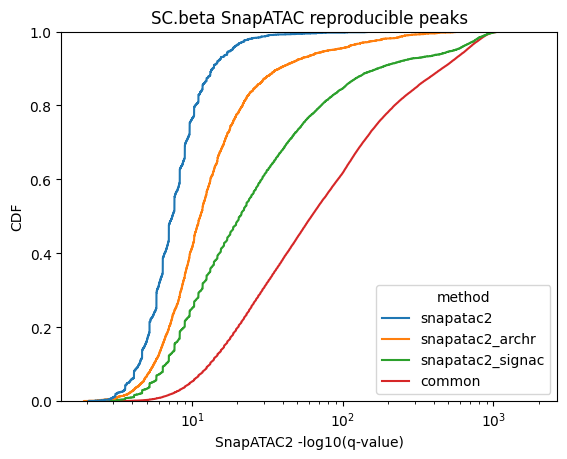

In [142]:
fig, ax = plt.subplots()
sns.ecdfplot(data=merged, x="qValue", hue="method", log_scale=True, ax=ax, hue_order=["snapatac2", "snapatac2_archr", "snapatac2_signac", "common"])
ax.set_xlabel("SnapATAC2 -log10(q-value)")
ax.set_ylabel("CDF")
#legend_labels = ["SnapATAC2 unique peaks", "SnapATAC2 and ArchR union peaks", "SnapATAC2 and Signac union peaks", "Common peaks"]
#ax.legend(legend_labels)
ax.set_title("SC.beta SnapATAC reproducible peaks")

# 1kb fixed width SC.beta peaks (no replicate for SnapATAC2)

In [229]:
# Peaks sets to compare
peakset1 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/snapatac2/filtered_no_replicate/filtered_peaks/SC.beta.filt.narrowPeak"
peakset2 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/filtered_archr/PeakCalls/SplitPeaks/SC.beta.bed"
peakset3 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/filtered_signac/peaks/SC.beta_peaks.narrowPeak"

In [230]:
# Load bedtool objects
peaks1_tool = pybedtools.BedTool(peakset1)
peaks2_tool = pybedtools.BedTool(peakset2)
peaks3_tool = pybedtools.BedTool(peakset3)
len(peaks1_tool), len(peaks2_tool), len(peaks3_tool)

(228782, 125307, 81321)

In [231]:
fixed_width_peaks1_tool = create_fixed_width_peaks(peakset1, 1000, 12)
fixed_width_peaks1_tool.saveas('snapatac2.filtered_no_replicate.SC.beta.fixed_width_peaks.bed')

fixed_width_peaks2_tool = peaks2_tool.slop(b=250, genome="hg38")
fixed_width_peaks2_tool.saveas('archr.SC.beta.fixed_width_peaks.bed')

fixed_width_peaks3_tool = create_fixed_width_peaks(peakset3, 1000, 9)
fixed_width_peaks3_tool.saveas('signac.SC.beta.fixed_width_peaks.bed')

Summit position is 18446744073714945169, setting summit to middle of the peak.
Summit position is 18446744073717307178, setting summit to middle of the peak.
Summit position is 18446744073895737214, setting summit to middle of the peak.
Summit position is 18446744073837305990, setting summit to middle of the peak.
Summit position is 18446744073807549533, setting summit to middle of the peak.
Summit position is 18446744073819447223, setting summit to middle of the peak.
Summit position is 18446744073844888371, setting summit to middle of the peak.
Summit position is 18446744073788965228, setting summit to middle of the peak.
Summit position is 18446744073710518835, setting summit to middle of the peak.
Summit position is 18446744073762409104, setting summit to middle of the peak.
Summit position is 18446744073730955535, setting summit to middle of the peak.
Summit position is 18446744073805612379, setting summit to middle of the peak.
Summit position is 18446744073767524223, setting sum

<BedTool(signac.SC.beta.fixed_width_peaks.bed)>

In [232]:
fixed_width_peaks1 = "snapatac2.filtered_no_replicate.SC.beta.fixed_width_peaks.bed"
fixed_width_peaks2 = "archr.SC.beta.fixed_width_peaks.bed"
fixed_width_peaks3 = "signac.SC.beta.fixed_width_peaks.bed"

In [186]:
venn_mpl(fixed_width_peaks1, fixed_width_peaks2, fixed_width_peaks3, outfn="fixed_width_SC.beta.filt_no_replicate.png", labels=["SnapATAC2 (non-reproducible)", "ArchR (filtered)", "Signac (filtered)"])

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	30267	31267	SC.beta_peak_1	672	.	9.18367	72.5008	67.2781	494

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	30267	31267	SC.beta_peak

In [233]:
venn2_mpl(fixed_width_peaks1, fixed_width_peaks2, outfn="fixed_width_SC.beta_filt_no_replicate_snapatac2_archr.png", labels=["SnapATAC2 (non-reproducible)", "ArchR (filtered)"], colors=["#1f77b4", "#2ca02c"])
venn2_mpl(fixed_width_peaks2, fixed_width_peaks1, outfn="fixed_width_SC.beta_filt_no_replicate_archr_snapatac2.png", labels=["ArchR (filtered)", "SnapATAC2 (non-reproducible)"], colors=["#2ca02c", "#1f77b4"])
venn2_mpl(fixed_width_peaks2, fixed_width_peaks3, outfn="fixed_width_SC.beta_filt_no_replicate_archr_signac.png", labels=["ArchR (filtered)", "Signac (filtered)"], colors=["#2ca02c", "#d62728"])
venn2_mpl(fixed_width_peaks3, fixed_width_peaks2, outfn="fixed_width_SC.beta_filt_no_replicate_signac_archr.png", labels=["Signac (filtered)", "ArchR (filtered)"], colors=["#d62728", "#2ca02c"])
venn2_mpl(fixed_width_peaks1, fixed_width_peaks3, outfn="fixed_width_SC.beta_filt_no_replicate_snapatac2_signac.png", labels=["SnapATAC2 (non-reproducible)", "Signac (filtered)"], colors=["#1f77b4", "#d62728"])
venn2_mpl(fixed_width_peaks3, fixed_width_peaks1, outfn="fixed_width_SC.beta_filt_no_replicate_signac_snapatac2.png", labels=["Signac (filtered)", "SnapATAC2 (non-reproducible)"], colors=["#d62728", "#1f77b4"])

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	30267	31267	SC.beta_peak_1	672	.	9.18367	72.5008	67.2781	494

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	30267	31267	SC.beta_peak_1	672	.	9.18367	72.5008	67.2781	494

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_

In [152]:
fixed_width_peaks1_tool = pybedtools.BedTool(fixed_width_peaks1)
fixed_width_peaks2_tool = pybedtools.BedTool(fixed_width_peaks2)
fixed_width_peaks3_tool = pybedtools.BedTool(fixed_width_peaks3)

In [153]:
snapatac2 = (fixed_width_peaks1_tool - fixed_width_peaks2_tool - fixed_width_peaks3_tool)
snapatac2_archr = (fixed_width_peaks1_tool + fixed_width_peaks2_tool - fixed_width_peaks3_tool)
snapatac2_signac = (fixed_width_peaks1_tool - fixed_width_peaks2_tool + fixed_width_peaks3_tool)
common = (fixed_width_peaks1_tool + fixed_width_peaks2_tool + fixed_width_peaks3_tool)
len(snapatac2), len(archr), len(snapatac2_archr), len(snapatac2_signac), len(common)

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.5265	45.5113	42.0924	179

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9602	10602	SC.beta_peak_39	420	.	13.

(97363, 58512, 25678, 25660, 80081)

In [154]:
snapatac2_df = snapatac2.to_dataframe(names=["chrom", "start", "end", "name", "X", "XX", "XXX", "score", "strand", "signalValue", "pValue", "qValue", "summit"])
snapatac2_df["method"] = "snapatac2"
snapatac2_archr_df = snapatac2_archr.to_dataframe(names=["chrom", "start", "end", "name", "X", "XX", "XXX", "score", "strand", "signalValue", "pValue", "qValue", "summit"])
snapatac2_archr_df["method"] = "snapatac2_archr"
snapatac2_signac_df = snapatac2_signac.to_dataframe(names=["chrom", "start", "end", "name", "X", "XX", "XXX", "score", "strand", "signalValue", "pValue", "qValue", "summit"])
snapatac2_signac_df["method"] = "snapatac2_signac"
common_df = common.to_dataframe(names=["chrom", "start", "end", "name", "X", "XX", "XXX", "score", "strand", "signalValue", "pValue", "qValue", "summit"])
common_df["method"] = "common"
merged = pd.concat([snapatac2_df, snapatac2_archr_df, snapatac2_signac_df, common_df])
merged.value_counts("method")

method
snapatac2           97363
common              80081
snapatac2_archr     25678
snapatac2_signac    25660
dtype: int64

Text(0.5, 1.0, 'SC.beta SnapATAC ALL peaks')

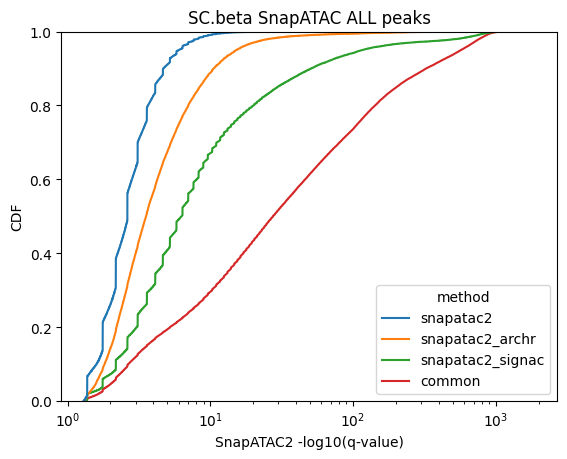

In [155]:
fig, ax = plt.subplots()
sns.ecdfplot(data=merged, x="qValue", hue="method", log_scale=True, ax=ax, hue_order=["snapatac2", "snapatac2_archr", "snapatac2_signac", "common"])
ax.set_xlabel("SnapATAC2 -log10(q-value)")
ax.set_ylabel("CDF")
#legend_labels = ["SnapATAC2 unique peaks", "SnapATAC2 and ArchR union peaks", "SnapATAC2 and Signac union peaks", "Common peaks"]
#ax.legend(legend_labels)
ax.set_title("SC.beta SnapATAC ALL peaks")

In [487]:
archr = (fixed_width_peaks2_tool - fixed_width_peaks1_tool - fixed_width_peaks3_tool)
archr_snapatac = (fixed_width_peaks2_tool + fixed_width_peaks1_tool - fixed_width_peaks3_tool)
archr_signac = (fixed_width_peaks2_tool + fixed_width_peaks3_tool - fixed_width_peaks1_tool)
common = (fixed_width_peaks2_tool + fixed_width_peaks1_tool + fixed_width_peaks3_tool)
len(archr), len(archr_snapatac), len(archr_signac), len(common)

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9605	10605	SC.beta_peak_51	442	.	10.8368	47.6305	44.2687	174

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9605	10605	SC.beta_peak_51	442	.	10.8368	47.6305	44.2687	174

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9605	10605	SC.beta_peak_51	442	.	10.8368	47.6305	44.2687	174

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9605	10605	SC.beta_peak_51	442	.	10.8368	47.6305	44.2687	174

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9605	10605	SC.beta_peak_51	442	.	10.8368	47.6305	44.2687	174

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9605	10605	SC.beta_peak_51	442	.	10.

(13783, 9883, 647, 52783)

In [488]:
archr_df = archr.to_dataframe()
archr_df["method"] = "archr"
archr_snapatac_df = archr_snapatac.to_dataframe()
archr_snapatac_df["method"] = "archr_snapatac"
archr_signac_df = archr_signac.to_dataframe()
archr_signac_df["method"] = "archr_signac"
common_df = common.to_dataframe()
common_df["method"] = "common"
merged = pd.concat([archr_df, archr_snapatac_df, archr_signac_df, common_df])
merged.value_counts("method")

method
common            52783
archr             13783
archr_snapatac     9883
archr_signac        647
dtype: int64

Text(0, 0.5, 'CDF')

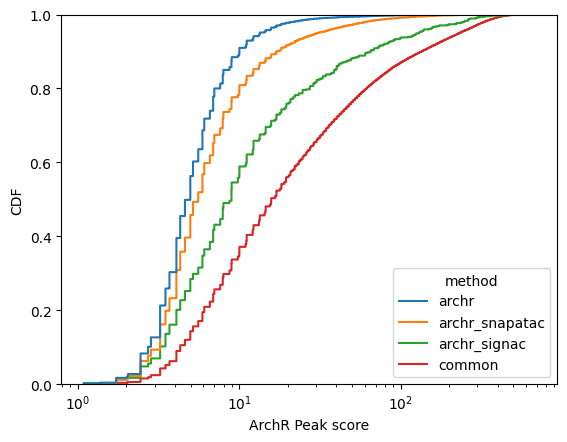

In [489]:
fig, ax = plt.subplots()
sns.ecdfplot(data=merged, x="score", hue="method", log_scale=True, ax=ax, hue_order=["archr", "archr_snapatac", "archr_signac", "common"])
ax.set_xlabel("ArchR Peak score")
ax.set_ylabel("CDF")
#legend_labels = ["ArchR unique peaks", "ArchR and SnapATAC2 union peaks", "ArchR and Signac union peaks", "Common peaks"]
#ax.legend(legend_labels)

In [490]:
signac = (fixed_width_peaks3_tool - fixed_width_peaks1_tool - fixed_width_peaks2_tool)
signac_snapatac = (fixed_width_peaks3_tool + fixed_width_peaks1_tool - fixed_width_peaks2_tool)
signac_archr = (fixed_width_peaks3_tool + fixed_width_peaks2_tool - fixed_width_peaks1_tool)
common = (fixed_width_peaks3_tool + fixed_width_peaks1_tool + fixed_width_peaks2_tool)
len(signac), len(signac_snapatac), len(signac_archr), len(common)

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	23671	24671	SC.beta_peak_1	28	.	2.69122	4.69674	2.81977	32

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	23671	24671	SC.beta_peak_1	28	.	2.69122	4.69674	2.81977	32

***** WARNING: File /tmp/pybedtools.40kettpw.tmp has inconsistent naming convention for record:
GL000195.1	23671	24671	SC.beta_peak_1	28	.	2.69122	4.69674	2.81977	32

***** WARNING: File /tmp/pybedtools.40kettpw.tmp has inconsistent naming convention for record:
GL000195.1	23671	24671	SC.beta_peak_1	28	.	2.69122	4.69674	2.81977	32

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	23671	24671	SC.beta_peak_1	28	.	2.69122	4.69674	2.81977	32

***** WARNING: File signac.SC.beta.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	23671	24671	SC.beta_peak_1

(2278, 53641, 231, 46252)

In [491]:
signac_df = signac.to_dataframe(names=["chrom", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "summit"])
signac_df["method"] = "signac"
signac_snapatac_df = signac_snapatac.to_dataframe(names=["chrom", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "summit"])
signac_snapatac_df["method"] = "signac_snapatac"
signac_archr_df = signac_archr.to_dataframe(names=["chrom", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "summit"])
signac_archr_df["method"] = "signac_archr"
common_df = common.to_dataframe(names=["chrom", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "summit"])
common_df["method"] = "common"
merged = pd.concat([signac_df, signac_snapatac_df, signac_archr_df, common_df])
merged.value_counts("method")

method
signac_snapatac    53641
common             46252
signac              2278
signac_archr         231
dtype: int64

Text(0, 0.5, 'CDF')

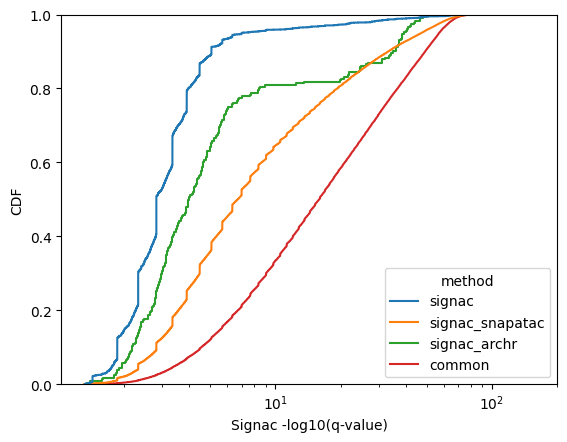

In [492]:
fig, ax = plt.subplots()
sns.ecdfplot(data=merged, x="qValue", hue="method", log_scale=True, ax=ax, hue_order=["signac", "signac_snapatac", "signac_archr", "common"])
ax.set_xlabel("Signac -log10(q-value)")
ax.set_ylabel("CDF")
#legend_labels = ["Signac unique peaks", "Signac and SnapATAC2 union peaks", "Signac and ArchR union peaks", "Common peaks"]
#ax.legend(legend_labels)

# 1kb fixed width SC.alpha peaks (replicate first for SnapATAC2)

In [287]:
# Peaks sets to compare
peakset1 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/snapatac2/filtered/filtered_peaks/SC.alpha.filt.narrowPeak"
peakset2 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/archr/PeakCalls/SplitPeaks/SC.alpha.bed"
peakset3 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/signac/peaks/SC.alpha_peaks.narrowPeak"

In [290]:
# Load bedtool objects
peaks1_tool = pybedtools.BedTool(peakset1)
peaks2_tool = pybedtools.BedTool(peakset2)
peaks3_tool = pybedtools.BedTool(peakset3)
len(peaks1_tool), len(peaks2_tool), len(peaks3_tool)

(58431, 55697, 83694)

In [291]:
fixed_width_peaks1_tool = create_fixed_width_peaks(peakset1, 1000, 12)
fixed_width_peaks1_tool.saveas('snapatac2.filtered.SC.alpha.fixed_width_peaks.bed')

fixed_width_peaks2_tool = peaks2_tool.slop(b=250, genome="hg38")
fixed_width_peaks2_tool.saveas('archr.SC.alpha.fixed_width_peaks.bed')

fixed_width_peaks3_tool = create_fixed_width_peaks(peakset3, 1000, 9)
fixed_width_peaks3_tool.saveas('signac.SC.alpha.fixed_width_peaks.bed')

<BedTool(signac.SC.alpha.fixed_width_peaks.bed)>

In [292]:
fixed_width_peaks1 = "snapatac2.filtered.SC.alpha.fixed_width_peaks.bed"
fixed_width_peaks2 = "archr.SC.alpha.fixed_width_peaks.bed"
fixed_width_peaks3 = "signac.SC.alpha.fixed_width_peaks.bed"

In [293]:
venn_mpl(fixed_width_peaks1, fixed_width_peaks2, fixed_width_peaks3, outfn="fixed_width_SC.alpha.png", labels=["SnapATAC2 (reproducible)", "ArchR", "Signac"])

***** WARNING: File signac.SC.alpha.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9604	10604	SC.alpha_peak_41	423	.	12.0725	45.6643	42.3692	175

***** WARNING: File signac.SC.alpha.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9604	10604	SC.alpha_peak_41	423	.	12.0725	45.6643	42.3692	175

***** WARNING: File signac.SC.alpha.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9604	10604	SC.alpha_peak_41	423	.	12.0725	45.6643	42.3692	175

***** WARNING: File signac.SC.alpha.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9604	10604	SC.alpha_peak_41	423	.	12.0725	45.6643	42.3692	175

***** WARNING: File signac.SC.alpha.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	15857	16857	SC.alpha_peak_1	62	.	4.1841	8.39265	6.25887	132

***** WARNING: File signac.SC.alpha.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	15857	16857	SC.

# 1kb fixed width SC.alpha peaks (no first for SnapATAC2)

In [294]:
# Peaks sets to compare
peakset1 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/snapatac2/filtered_no_replicate/filtered_peaks/SC.alpha.filt.narrowPeak"
peakset2 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/archr/PeakCalls/SplitPeaks/SC.alpha.bed"
peakset3 = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/signac/peaks/SC.alpha_peaks.narrowPeak"

In [295]:
# Load bedtool objects
peaks1_tool = pybedtools.BedTool(peakset1)
peaks2_tool = pybedtools.BedTool(peakset2)
peaks3_tool = pybedtools.BedTool(peakset3)
len(peaks1_tool), len(peaks2_tool), len(peaks3_tool)

(194609, 55697, 83694)

In [296]:
fixed_width_peaks1_tool = create_fixed_width_peaks(peakset1, 1000, 12)
fixed_width_peaks1_tool.saveas('snapatac2.filtered_no_replicate.SC.alpha.fixed_width_peaks.bed')

fixed_width_peaks2_tool = peaks2_tool.slop(b=250, genome="hg38")
fixed_width_peaks2_tool.saveas('archr.SC.alpha.fixed_width_peaks.bed')

fixed_width_peaks3_tool = create_fixed_width_peaks(peakset3, 1000, 9)
fixed_width_peaks3_tool.saveas('signac.SC.alpha.fixed_width_peaks.bed')

Summit position is 18446744073907337450, setting summit to middle of the peak.
Summit position is 18446744073735627656, setting summit to middle of the peak.
Summit position is 18446744073826957415, setting summit to middle of the peak.
Summit position is 18446744073838838617, setting summit to middle of the peak.
Summit position is 18446744073840404379, setting summit to middle of the peak.
Summit position is 18446744073750544779, setting summit to middle of the peak.
Summit position is 18446744073828971421, setting summit to middle of the peak.


<BedTool(signac.SC.alpha.fixed_width_peaks.bed)>

In [297]:
fixed_width_peaks1 = "snapatac2.filtered_no_replicate.SC.alpha.fixed_width_peaks.bed"
fixed_width_peaks2 = "archr.SC.alpha.fixed_width_peaks.bed"
fixed_width_peaks3 = "signac.SC.alpha.fixed_width_peaks.bed"

In [298]:
venn_mpl(fixed_width_peaks1, fixed_width_peaks2, fixed_width_peaks3, outfn="fixed_width_SC.alpha_no_replicate.png", labels=["SnapATAC2", "ArchR", "Signac"])

***** WARNING: File signac.SC.alpha.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9604	10604	SC.alpha_peak_41	423	.	12.0725	45.6643	42.3692	175

***** WARNING: File signac.SC.alpha.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9604	10604	SC.alpha_peak_41	423	.	12.0725	45.6643	42.3692	175

***** WARNING: File signac.SC.alpha.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9604	10604	SC.alpha_peak_41	423	.	12.0725	45.6643	42.3692	175

***** WARNING: File signac.SC.alpha.fixed_width_peaks.bed has inconsistent naming convention for record:
chr1	9604	10604	SC.alpha_peak_41	423	.	12.0725	45.6643	42.3692	175

***** WARNING: File signac.SC.alpha.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	15857	16857	SC.alpha_peak_1	62	.	4.1841	8.39265	6.25887	132

***** WARNING: File signac.SC.alpha.fixed_width_peaks.bed has inconsistent naming convention for record:
GL000195.1	15857	16857	SC.

# Scratch

In [35]:
from six.moves import urllib
import base64
def venn_gchart(a, b, c=None, colors=None, labels=None, size="300x300"):
    """
    a, b, and c are filenames to BED-like files.

    *colors* is a list of 3 hex colors

    *labels* is a list of 3 labels

    *outfn* is the output PNG you want to create.

    *size* is the size in pixels for the PNG
    """
    a = pybedtools.BedTool(a)
    b = pybedtools.BedTool(b)
    if c:
        c = pybedtools.BedTool(c)

    # The order of values is meaningful to the API, see
    # http://code.google.com/apis/chart/docs/gallery/venn_charts.html
    if c:
        vals = [
            len(a),
            len(b),
            len(c),
            len(a + b),
            len(a + c),
            len(b + c),
            len(a + b + c),
        ]
    else:
        # insert 0 for size of 3rd circle.
        vals = [len(a), len(b), 0, len(a + b)]
        labels = labels[:2]
    # API doesn't seem to like large numbers, so get fractions instead, then
    # join make a comma-separated list of values.
    mx = float(max(vals))
    vals = [round(i / mx, 4) for i in vals]
    valstr = ",".join(map(str, vals))

    data = {"cht": "v", "chs": size, "chd": "t:" + valstr}

    # Add the optional data, if specified
    if labels:
        data["chdl"] = "|".join(labels)
    if colors:
        data["chco"] = ",".join(colors)
    return data


def gchart(data, outfn="out.png"):
    """
    Sends data to Google Chart API
    """
    data = urllib.parse.urlencode(data)
    binary_data = data.encode("UTF-8")

    url = "https://chart.googleapis.com/chart?"

    # Request and get the PNG
    req = urllib.request.Request(url, binary_data)
    print(url + data)
    response = urllib.request.urlopen(req)
    f = open(outfn, "w")
    response = base64.b64decode(response.read())

    f.write(response)
    f.close()

In [36]:
data = venn_gchart(
    a=peakset1,
    b=peakset2,
    c=peakset3,
    labels=["SnapATAC2", "SnapATAC2 (reproducible)", "ArchR"],
)
gchart(data, outfn="/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/fig/test_venn_gchart.png")

https://chart.googleapis.com/chart?cht=v&chs=300x300&chd=t%3A1.0%2C0.3021%2C0.555%2C0.3031%2C0.3868%2C0.2667%2C0.2673&chdl=SnapATAC2%7CSnapATAC2+%28reproducible%29%7CArchR
b"<\xd1\x88\x1c4[(`\xc8\x0c\x04\xf1\xc5?\xd9\x90F\xfe\x125{\xb9\xc81\xbdr]\x9c\x12\xb9\xcb7)\x17t\x01\x1e\x00A\xf2\x91w@\x11\xe0\x04\x1f)\x17t\x01\x1e\x00A\xf2\x91w@\x11\xe0\x04\x1f)\x17t\x01\x1e\x00A\xf2\x91w@\x11\xe0\x04\x1f)\x17t\x01\x1e\x00A\xf2\x91w@\x11\xe0\x04\x1f)\x17t\x01\x1e\x00A\xf2\x91w@\x11\xe0\x04\x1f)\x17t\x01\x1e\x00A\xf2\x91w\x7f\xcc\xee\xb6\xde\xc00[k\x05\xa8\xb2\x1e\x1dy\xd0\xe2Gb\xdbC\xf4\xf2\x0b\xd8<N`\xed\xb2\x04\xa2\xf638\r&\xc1%E\xde\xbbj`\xe7\xb0]\xbc(F\x90X\xbd\x82\xf0\xa1\x17,\x18f\x83\x97\xb0\xcb\xeaa\x8c\x1a\xad\xc2\xe5\x12\x18\xd7\xb2\xcdY\xd0\xfe\x03\x9b\xae\xed\xa4*h'\xff\xc9\xaf\xcf\xb0\rK\x8ej\xb2\x98\xf6)^W\x9a\xff\xe7\xe8\xeed\x04&\xe6B\xe6\xc7\xd8\xbem\xbc\xda\xf1\x9a\xd2R\x9f\x10\x13\xe2:eo\xa08\xa0\xe2\xd8i\x95\x0b\xe6\xe5)\xb0p?\t\xa4ns\xfc\xac\x92\xf1*\xa4\x8eA\x1aHG\xc7\xba"


TypeError: write() argument must be str, not bytes

In [58]:
peaks1_tool.head()

chr1	9863	10364
 chr1	17263	17764
 chr1	29129	29630
 chr1	91247	91748
 chr1	134960	135461
 chr1	181197	181698
 chr1	180595	181096
 chr1	186773	187274
 chr1	191220	191721
 chr1	267754	268255
 

In [60]:
peaks3_tool.head()

chr1	804701	805202	SC.alpha	16.5771	.
 chr1	818502	819003	SC.beta	3.69781	.
 chr1	819660	820161	SC.beta	3.23627	.
 chr1	821030	821531	SC.beta	3.23627	.
 chr1	822053	822554	SC.EC	2.67103	.
 chr1	826489	826990	SC.beta	7.01473	.
 chr1	827295	827796	SC.beta	247.37	.
 chr1	830671	831172	SC.alpha	11.9789	.
 chr1	832048	832549	SC.beta	13.4173	.
 chr1	850297	850798	SC.alpha	4.78467	.
 

In [79]:
a_with_b = peaks4_tool.intersect(peaks1_tool, u=True)
len(a_with_b)

***** WARNING: File /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/signac/peaks/SC.beta_peaks.narrowPeak has inconsistent naming convention for record:
GL000195.1	24139	24362	SC.beta_peak_1	28	.	2.69122	4.69674	2.81977	32

***** WARNING: File /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/signac/peaks/SC.beta_peaks.narrowPeak has inconsistent naming convention for record:
GL000195.1	24139	24362	SC.beta_peak_1	28	.	2.69122	4.69674	2.81977	32



98804

In [50]:
a_with_b.

<BedTool(/tmp/pybedtools.wuak00w0.tmp)>

In [56]:
len(peaks2_tool)

99020

In [89]:
import pickle

In [118]:
cistopic_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/pycistopic/archr/A2_control_archr_peakset.pkl"

In [119]:
with open(cistopic_path, "rb") as f:
    cistopic = pickle.load(f)

In [122]:
cistopic.binary_matrix.shape

(181926, 11054)

In [121]:
cistopic.region_data

,Chromosome,Start,End,Width,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc
chr1:804702-805202,chr1,804702,805202,500,361,2.557507,219,2.340444
chr1:818503-819003,chr1,818503,819003,500,142,2.152288,98,1.991226
chr1:819661-820161,chr1,819661,820161,500,198,2.296665,135,2.130334
chr1:821031-821531,chr1,821031,821531,500,242,2.383815,171,2.232996
chr1:822054-822554,chr1,822054,822554,500,221,2.344392,162,2.209515
...,...,...,...,...,...,...,...,...
chrX:155767249-155767749,chrX,155767249,155767749,500,310,2.491362,184,2.264818
chrX:155820080-155820580,chrX,155820080,155820580,500,462,2.664642,264,2.421604
chrX:155880505-155881005,chrX,155880505,155881005,500,367,2.564666,273,2.436163
chrX:155881015-155881515,chrX,155881015,155881515,500,2627,3.419460,1373,3.137671


In [4]:
todo = pd.read_csv("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/filtered_signac/matrix/features copy.tsv", header=None)

In [6]:
# split by "-" into chr, start, end
todo = todo[0].str.split("-", expand=True)

In [7]:
# Save as consensus_peaks.bed
todo.to_csv("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/filtered_signac/peaks/consensus_peaks.bed", sep="\t", index=False, header=False)